In [1]:
import sys
from tqdm import tqdm as tqdm
sys.path.insert(0,'/home/olgan96/.env/lib/python3.11/site-packages/')

In [2]:
import pandas as pd
import anndata
import anndata as ad
import numpy as np
from scipy import sparse
from tqdm import tqdm
import scanpy as sc
import matplotlib.pyplot as plt


/home/olgan96/.env/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
df = anndata.read_h5ad('../../NO_BACKUP/tahoe/plates_filtered/plate14_filtered.h5ad')

In [4]:
!mkdir ../../NO_BACKUP/tahoe/pseudobulks/plate14

In [5]:
np.random.seed(42)

In [6]:
df_sm_cl = df.obs['cell_line'].astype(str) + '_' + df.obs['drug'].astype(str)

In [7]:
df_sample_cell_line = df.obs['sample'].astype(str) + '_' + df.obs['cell_line'].astype(str)

In [8]:
df.obs['sm_cl'] = df_sm_cl.astype("category")

In [9]:
df.obs['sample_cell_line'] = df_sample_cell_line.astype("category")

### subsample visualization

In [10]:
indices = np.random.choice(list(df.obs.index), size=1000)
subsample = df[indices]

(array([994.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

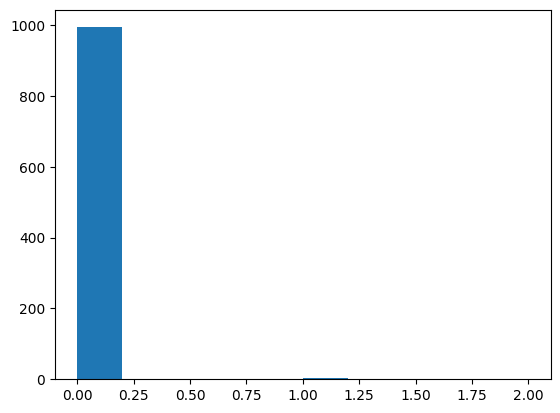

In [11]:
plt.hist(subsample.X[1].todense().tolist()[0][:1000])

In [12]:
pd.read_csv('../../NO_BACKUP/tahoe/metadata/obs_metadata_descriptions.tsv', sep='\t')

,Column,description
0,plate,plate number
1,BARCODE_SUB_LIB_ID,cell identifier
2,sample,"unique treatment identifier, distinguishes rep..."
3,gene_count,number of genes with at least one count
4,tsc_count,"number of transcripts, aka UMI count"
5,mread_count,number of reads per cell
6,drugname_drugconc,"drug name, concentration and concentration unit"
7,drug,"drug name, as used in the drugname_drugconc field"
8,cell_line,cell line Cellosaurus identifier
9,sublibrary,sublibrary id (related to library prep and seq...


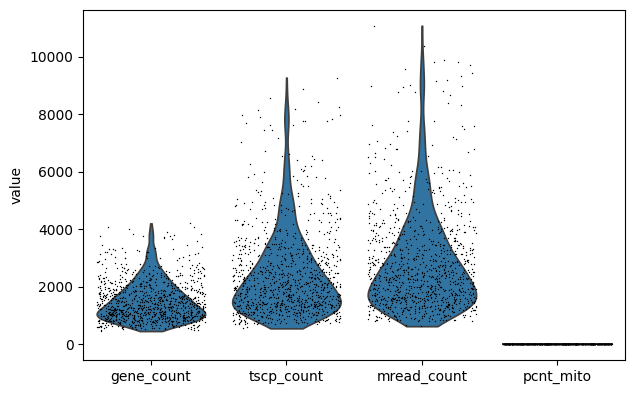

In [13]:
sc.pl.violin(subsample, ['gene_count', 'tscp_count', 'mread_count','pcnt_mito'],
             jitter=0.4)

In [14]:
subsample[(subsample.obs.gene_count < 2000) & 
(subsample.obs.tscp_count < 3000) & 
(subsample.obs.mread_count < 5000),:].shape

(739, 12124)

In [15]:
# Do the filtering
subsample = subsample[(subsample.obs.gene_count < 2000) & 
(subsample.obs.tscp_count < 3000) & 
(subsample.obs.mread_count < 5000),:]

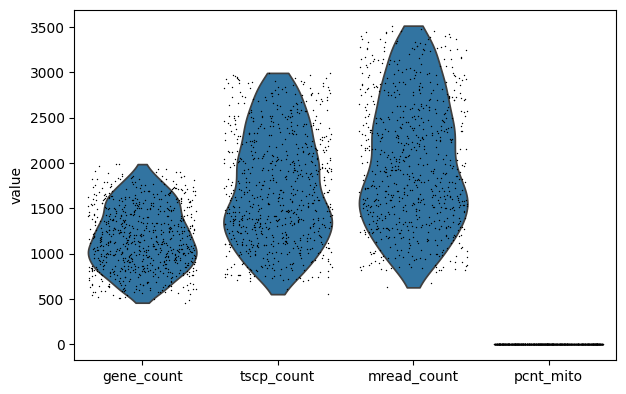

In [16]:
sc.pl.violin(subsample, ['gene_count', 'tscp_count', 'mread_count','pcnt_mito'],
             jitter=0.4)

In [17]:
sc.pp.filter_cells(subsample, min_counts=3)
sc.pp.filter_cells(subsample, max_counts=2000)

/home/olgan96/.env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:174: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


### subsample end

In [18]:
# Do the filtering
df = df[(df.obs.gene_count < 2000) & 
(df.obs.tscp_count < 3000) & 
(df.obs.mread_count < 5000),:]

sc.pp.filter_cells(df, min_counts=3)
sc.pp.filter_cells(df, max_counts=2000)

/home/olgan96/.env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:174: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [19]:
df_sm_cl_cnt = pd.DataFrame(df_sm_cl).value_counts()

In [20]:
pd.DataFrame(df_sm_cl).value_counts().mean()#[df_sm_cl == 'CVCL_0292_Sapanisertib']

np.float64(1349.2993445010925)

In [21]:
frequent_exp = df.obs[~df.obs['sm_cl'].isin(df_sm_cl_cnt[df_sm_cl_cnt < 100].reset_index()[0].unique())].index

In [22]:
3382521 / 20

169126.05

In [23]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post:
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    https://github.com/openproblems-bio/task_perturbation_prediction/blob/main/src/process_dataset/compute_pseudobulk/script.py
    """

    # assert pd.api.types.is_categorical_dtype(adata.obs[col])
    assert isinstance(adata.obs[col].dtypes, pd.CategoricalDtype)

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values
    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
    sum_adata = ad.AnnData(
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    if adata.X is not None:
        sum_adata.X = indicator @ adata.X

    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = list(set(adata.obs.columns) - set([col]))

    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [24]:
ids = list(df[frequent_exp].obs.index)
for i in tqdm(range(100)):
    bootstrap_ids = np.random.choice(ids, size=150000)
    bulked = sum_by(df[bootstrap_ids], 'sample_cell_line')
    #break
    bulked.write_h5ad('../../NO_BACKUP/tahoe/pseudobulks/plate14/' + 'bulk_' + str(i+1) + '.h5ad')

100%|██████████| 100/100 [11:04<00:00,  6.65s/it]


In [38]:
df.obs['sample_cell_line']#.unique()

BARCODE_SUB_LIB_ID
27_143_054-lib_2237    smp_2385_CVCL_0023
78_151_030-lib_1709    smp_2436_CVCL_0218
27_150_180-lib_1766    smp_2385_CVCL_1055
89_153_134-lib_1701    smp_2447_CVCL_1285
32_041_110-lib_2238    smp_2390_CVCL_1731
                              ...        
96_187_140-lib_2253    smp_2454_CVCL_1495
96_188_009-lib_2253    smp_2454_CVCL_0428
96_189_074-lib_2253    smp_2454_CVCL_0546
96_190_059-lib_2253    smp_2454_CVCL_0152
96_190_165-lib_2253    smp_2454_CVCL_1381
Name: sample_cell_line, Length: 2262974, dtype: category
Categories (1962, object): ['smp_2363_CVCL_0023', 'smp_2363_CVCL_0028', 'smp_2363_CVCL_0069', 'smp_2363_CVCL_0099', ..., 'smp_2454_CVCL_1717', 'smp_2454_CVCL_1724', 'smp_2454_CVCL_1731', 'smp_2454_CVCL_C466']

In [ ]:
df.obs

In [34]:
pd.read_csv('../../NO_BACKUP/tahoe/metadata/obs_metadata_descriptions.tsv', sep='\t')[pd.read_csv('../../NO_BACKUP/tahoe/metadata/obs_metadata_descriptions.tsv', sep='\t')['Column'] == 'sample'].values#['sample']

array([['sample',
        'unique treatment identifier, distinguishes replicated treatments']],
      dtype=object)

In [35]:
pd.read_csv('../../NO_BACKUP/tahoe/metadata/obs_metadata_descriptions.tsv', sep='\t')

,Column,description
0,plate,plate number
1,BARCODE_SUB_LIB_ID,cell identifier
2,sample,"unique treatment identifier, distinguishes rep..."
3,gene_count,number of genes with at least one count
4,tsc_count,"number of transcripts, aka UMI count"
5,mread_count,number of reads per cell
6,drugname_drugconc,"drug name, concentration and concentration unit"
7,drug,"drug name, as used in the drugname_drugconc field"
8,cell_line,cell line Cellosaurus identifier
9,sublibrary,sublibrary id (related to library prep and seq...
